# Gradient Visualization for Radial 1D Stellar Wind Simulation

## Imports

In [1]:
# numerics
import jax
import jax.numpy as jnp
import numpy as np
import optax

# timing
from timeit import default_timer as timer

# plotting
import matplotlib.pyplot as plt

# fluids
from jf1uids.boundaries import OPEN_BOUNDARY, REFLECTIVE_BOUNDARY
from jf1uids.geometry import SPHERICAL
from jf1uids.physics_modules.stellar_wind import WindParams
from jf1uids.postprocessing import shock_sensor, strongest_shock_radius
from jf1uids.simulation_config import SimulationConfig
from jf1uids.simulation_helper_data import get_helper_data
from jf1uids.simulation_params import SimulationParams
from jf1uids.time_integration import time_integration
from jf1uids.fluid import primitive_state

# units
from jf1uids.unit_helpers import CodeUnits
from astropy import units as u
import astropy.constants as c
from astropy.constants import m_p

# wind-specific
from weaver import Weaver
from jax import grad

# # for now using CPU as of outdated NVIDIA Driver
jax.config.update('jax_platform_name', 'cpu')

# # 64-bit precision
jax.config.update("jax_enable_x64", True)

: 

## Initiating the stellar wind simulation

In [2]:
print("👷 Setting up simulation...")

# simulation settings
gamma = 5/3

# spatial domain
alpha = SPHERICAL
box_size = 1.0
num_cells = 2000
dx = box_size / (num_cells - 1)

fixed_timestep = True
num_timesteps = 60000

# introduce constants to 
# make this more readable
left_boundary = REFLECTIVE_BOUNDARY
right_boundary = OPEN_BOUNDARY

# activate stellar wind
stellar_wind = True

# setup simulation config
config = SimulationConfig(
    alpha_geom = alpha,
    box_size = box_size, 
    num_cells = num_cells,
    left_boundary = left_boundary, 
    right_boundary = right_boundary, 
    stellar_wind = stellar_wind,
    fixed_timestep = fixed_timestep,
    num_timesteps = num_timesteps
)

helper_data = get_helper_data(config)

👷 Setting up simulation...


## Setting the simulation parameters and initial state

In [8]:
# code units
code_length = 3 * u.parsec
code_mass = 1e-3 * u.M_sun
code_velocity = 1 * u.km / u.s
code_units = CodeUnits(code_length, code_mass, code_velocity)

# time domain
C_CFL = 0.8
t_final = 2.5 * 1e4 * u.yr
t_end = t_final.to(code_units.code_time).value
dt_max = 0.0001 * t_end


# wind parameters
M_star = 40 * u.M_sun
wind_final_velocity = 2000 * u.km / u.s
wind_mass_loss_rate = 2.965e-3 / (1e6 * u.yr) * M_star

wind_params = WindParams(
    wind_mass_loss_rate = wind_mass_loss_rate.to(code_units.code_mass / code_units.code_time).value,
    wind_final_velocity = wind_final_velocity.to(code_units.code_velocity).value
)

params = SimulationParams(
    C_cfl = C_CFL,
    dt_max = dt_max,
    dx = dx,
    gamma = gamma,
    t_end = t_end,
    wind_params=wind_params
)

# homogeneous initial state
rho_0 = 2 * c.m_p / u.cm**3
p_0 = 3e4 * u.K / u.cm**3 * c.k_B

rho_init = jnp.ones(num_cells) * rho_0.to(code_units.code_density).value
u_init = jnp.zeros(num_cells)
p_init = jnp.ones(num_cells) * p_0.to(code_units.code_pressure).value

# get initial state
initial_state = primitive_state(rho_init, u_init, p_init)

## Simulation and Gradient

In [4]:
final_state = time_integration(initial_state, config, params, helper_data)

vel_sens = jax.jacfwd(lambda velocity: time_integration(initial_state, config, SimulationParams(
    C_cfl=params.C_cfl,
    dt_max=params.dt_max,
    dx=params.dx,
    gamma=params.gamma,
    t_end=params.t_end,
    wind_params=WindParams(
        wind_mass_loss_rate=params.wind_params.wind_mass_loss_rate,
        wind_final_velocity=velocity
    )
), helper_data))(params.wind_params.wind_final_velocity)

## Visualization

👷 generating plots


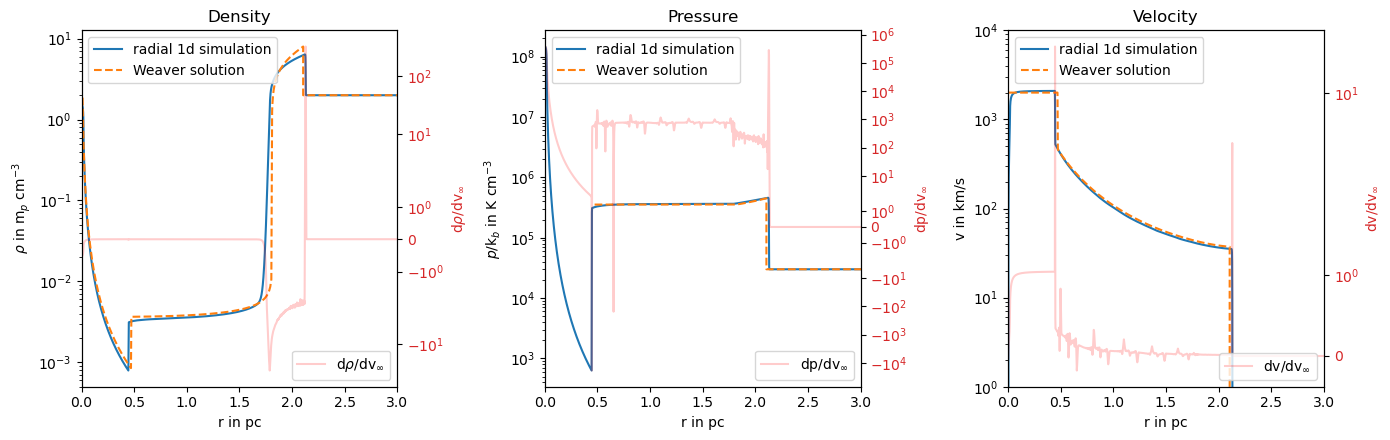

In [5]:
def plot_weaver_comparison(axs, final_state, params, helper_data, code_units, rho_0, p_0):
    print("👷 generating plots")

    rho, vel, p = final_state
    internal_energy = p / ((gamma - 1) * rho)

    rho = rho * code_units.code_density
    vel = vel * code_units.code_velocity
    p = p * code_units.code_pressure

    r = helper_data.geometric_centers * code_units.code_length

    # get weaver solution
    weaver = Weaver(
        params.wind_params.wind_final_velocity * code_units.code_velocity,
        params.wind_params.wind_mass_loss_rate * code_units.code_mass / code_units.code_time,
        rho_0,
        p_0
    )
    current_time = params.t_end * code_units.code_time

    # density
    r_density_weaver, density_weaver = weaver.get_density_profile(0.01 * u.parsec, 3.5 * u.parsec, current_time)
    r_density_weaver = r_density_weaver.to(u.parsec)
    density_weaver = (density_weaver / m_p).to(u.cm**-3)

    # velocity
    r_velocity_weaver, velocity_weaver = weaver.get_velocity_profile(0.01 * u.parsec, 3.5 * u.parsec, current_time)
    r_velocity_weaver = r_velocity_weaver.to(u.parsec)
    velocity_weaver = velocity_weaver.to(u.km / u.s)

    # pressure
    r_pressure_weaver, pressure_weaver = weaver.get_pressure_profile(0.01 * u.parsec, 3.5 * u.parsec, current_time)
    r_pressure_weaver = r_pressure_weaver.to(u.parsec)
    pressure_weaver = (pressure_weaver / c.k_B).to(u.cm**-3 * u.K)

    axs[0].set_yscale("log")
    axs[0].plot(r.to(u.parsec), (rho / m_p).to(u.cm**-3), label="radial 1d simulation")
    axs[0].plot(r_density_weaver, density_weaver, "--", label="Weaver solution")
    axs[0].set_title("Density")
    axs[0].set_ylabel(r"$\rho$ in m$_p$ cm$^{-3}$")
    axs[0].set_xlim(0, 3)
    # xlabel
    axs[0].set_xlabel("r in pc")
    # xlim 0 to 0.3
    # show legend
    axs[0].legend(loc="upper left")

    axs[1].set_yscale("log")
    axs[1].plot(r.to(u.parsec), (p / c.k_B).to(u.K / u.cm**3), label="radial 1d simulation")
    axs[1].plot(r_pressure_weaver, pressure_weaver, "--", label="Weaver solution")
    axs[1].set_title("Pressure")
    axs[1].set_ylabel(r"$p$/k$_b$ in K cm$^{-3}$")
    axs[1].set_xlim(0, 3)
    # xlabel
    axs[1].set_xlabel("r in pc")
    # show legend
    axs[1].legend(loc="upper left")


    axs[2].set_yscale("log")
    axs[2].plot(r.to(u.parsec), vel.to(u.km / u.s), label="radial 1d simulation")
    axs[2].plot(r_velocity_weaver, velocity_weaver, "--", label="Weaver solution")
    axs[2].set_title("Velocity")
    # ylim 1 to 1e4 km/s
    axs[2].set_ylim(1, 1e4)
    axs[2].set_xlim(0, 3)
    axs[2].set_ylabel("v in km/s")
    # xlabel
    axs[2].set_xlabel("r in pc")
    # show legend upper left
    axs[2].legend(loc="upper left")

def twin_x_sensitivity_plot(axs, vel_sens):

    color = 'tab:red'

    # plot sensitivity on twin x axis
    ax0twin = axs[0].twinx()
    ax1twin = axs[1].twinx()
    ax2twin = axs[2].twinx()

    rho_sens_vel, vel_sens_vel, p_sens_vel = vel_sens
    r = helper_data.geometric_centers * code_units.code_length

    ax0twin.plot(r.to(u.parsec), rho_sens_vel, color="red", label=r"d$\rho$/dv$_\infty$", alpha = 0.2)
    ax0twin.set_ylabel(r"d$\rho$/dv$_\infty$", color=color)
    # legend upper right
    ax0twin.legend(loc = "lower right")
    ax0twin.tick_params(axis='y', labelcolor=color)
    ax0twin.set_yscale('symlog')

    ax1twin.plot(r.to(u.parsec), p_sens_vel, color="red", label=r"dp/dv$_\infty$", alpha = 0.2)
    ax1twin.set_ylabel(r"dp/dv$_\infty$", color=color)
    ax1twin.legend(loc = "lower right")
    ax1twin.tick_params(axis='y', labelcolor=color)
    ax1twin.set_yscale('symlog')

    ax2twin.plot(r.to(u.parsec), vel_sens_vel, color="red", label=r"dv/dv$_\infty$", alpha = 0.2)
    ax2twin.set_ylabel(r"dv/dv$_\infty$", color=color)
    ax2twin.legend(loc = "lower right")
    ax2twin.tick_params(axis='y', labelcolor=color)
    ax2twin.set_yscale('symlog')

fig, axs = plt.subplots(1, 3, figsize=(14, 4.5))
plot_weaver_comparison(axs, final_state, params, helper_data, code_units, rho_0, p_0)
twin_x_sensitivity_plot(axs, vel_sens)

plt.tight_layout()

plt.savefig("weaver_sensitivity.png")

